In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import scipy.stats as st

from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from adtk.detector import AutoregressionAD
from adtk.visualization import plot as adtkplot


RANDOM_STATE = 7
CONTAMINATION = 0.01
DATA_PATH = 'all_LAT_uns.csv'
TURN_COLS = [
    'NewRotRateY',
    'NewRotRateZ',
    'NewAccelX',
]


In [2]:
df_all = pd.read_csv(DATA_PATH)
df = df_all[TURN_COLS]

rng = np.random.default_rng(RANDOM_STATE)
sample_indices = rng.choice(len(df), 5_000)
is_sample = np.full(len(df), False, bool)
is_sample[sample_indices] = True

def plot_outliers(data, preds, mask=None, title=None):
    if mask is not None:
        preds = preds[mask]
        data = data[mask]
    colors = np.where(preds == 1, 'regular', 'outlier')
    fig = px.scatter_3d(
        data, *TURN_COLS,
        color=colors,
        color_discrete_sequence=['blue', 'red'],
        title=f'{title} ({len(data)} samples)'
    )
    fig.show()


In [3]:
# ELLIPTIC ENVELOPE

ee = EllipticEnvelope(contamination=CONTAMINATION, random_state=RANDOM_STATE)
ee_preds =ee.fit_predict(df)

plot_outliers(
    df, ee_preds, mask=is_sample,
    title=f'Gaussian Outlier Detection (contamination={ee.contamination})',
)


In [4]:
# LOCAL OUTLIER FACTOR
lof = LocalOutlierFactor(n_neighbors=4, contamination=CONTAMINATION)
lof_preds = lof.fit_predict(df)

plot_outliers(
    df, lof_preds, mask=None,
    title=f'LOF (contamination={lof.contamination})'
)

In [5]:
# ISOLATION FOREST
isfo = IsolationForest(n_estimators=100, contamination=CONTAMINATION)
isfo_preds = isfo.fit_predict(df)

plot_outliers(
    df, isfo_preds, mask=is_sample,
    title=f'Isolation Forest (contamination={isfo.contamination})'
)


c:\Users\konpa\projects\datadriven-exercises\assignment3\env\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [6]:
normsq = (df ** 2).sum(axis=1) ** 0.5
time_index = pd.date_range(start='2021', periods=len(normsq), freq='1S')
normsq = normsq.set_axis(time_index)
normsq.name = ' + '.join(f'{col} ^ 2' for col in TURN_COLS)


[<AxesSubplot:>]

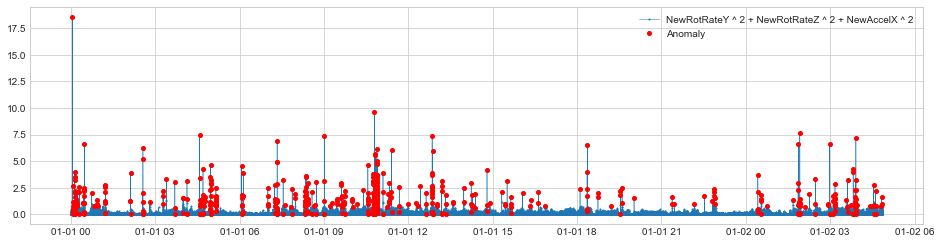

In [7]:
# Auto-Regression
# c is used to compute the interval where the regular values lie:
# [Q1−c*IQR, Q3+c*IQR] where IQR=Q3−Q1 and Q1, Q3 the the 25% and 75% quantiles]
c = 20.0
arad = AutoregressionAD(n_steps=10, step_size=1, c=c, side='both')
arad_preds = arad.fit_detect(normsq)

adtkplot(normsq, anomaly=arad_preds, anomaly_color="red", anomaly_tag="marker")